In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt 

from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
import scipy.cluster.hierarchy as sch
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

import warnings 
warnings.simplefilter("ignore")

pd.set_option("display.max_rows", 999)
pd.set_option("display.max_columns", 999)

In [2]:
# Importation du dataset
data = pd.read_csv('data/nettoyage_de_donnees.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87493 entries, 0 to 87492
Data columns (total 35 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   customer_unique_id              87493 non-null  object 
 1   commandes_quantites             87493 non-null  int64  
 2   order_purchase_timestamp        87493 non-null  object 
 3   payment_installments            87493 non-null  int64  
 4   prix_total                      87493 non-null  float64
 5   review_score                    87493 non-null  int64  
 6   autour_de_Sao_Paulo             87493 non-null  float64
 7   product_photos_qty              87493 non-null  float64
 8   client_inactif_jour             87493 non-null  int64  
 9   delai_livraison                 87493 non-null  int64  
 10  dimension_m3                    87493 non-null  float64
 11  ans                             87493 non-null  int64  
 12  mois                            

In [4]:
# Toutes les valeurs sont renseignées
data.isna().sum().sum()

0

In [5]:
# Dataset 2 clients au hasard 
data.sample(2).T

,81428,12636
customer_unique_id,8a4cddc3974dff18373cfdeebd89ee50,93d03be335754f985542d239c21e0002
commandes_quantites,1,1
order_purchase_timestamp,2018-04-19 12:37:50,2017-10-02 16:55:39
payment_installments,5,3
prix_total,103.89,76.08
review_score,5,5
autour_de_Sao_Paulo,345.8,124.8
product_photos_qty,1,4
client_inactif_jour,188,387
delai_livraison,11,7


In [6]:
# On va l'enregistrer et on l'utilisera ultérieurement 
df_avec_date = data.copy()

In [7]:
data.drop(columns='order_purchase_timestamp',inplace=True)

In [8]:
data.set_index('customer_unique_id',inplace=True)

In [9]:
# Variables à standardisées
variables_a_stand  = ['commandes_quantites','payment_installments',
       'prix_total', 'review_score', 'autour_de_Sao_Paulo',
       'product_photos_qty', 'client_inactif_jour', 'delai_livraison',
       'dimension_m3', 'ans', 'mois', 'jour']

# PCA

In [10]:
data_pca = data.copy()

In [11]:
# Un objet
ss = StandardScaler()

In [12]:
# Standardisation 
data_pca[variables_a_stand] = ss.fit_transform(data_pca[variables_a_stand])

In [13]:
# L'objectif est d'expliquer le data_pcaset (à 95 %) avec moins de variables.
pca=PCA(n_components=0.98)
pca.fit(data_pca)
pca.explained_variance_ratio_ 


array([0.14574235, 0.1185128 , 0.09767748, 0.08020069, 0.07184525,
       0.07126875, 0.06839221, 0.06468237, 0.06375627, 0.04606225,
       0.03677881, 0.02182181, 0.01792912, 0.01262963, 0.01183207,
       0.01127568, 0.0107562 , 0.00832493, 0.00630893, 0.00587875,
       0.00523465, 0.00424482])

In [14]:
# On a obtenu 22 projections
pca_projection = pca.transform(data_pca)
pca_projection.shape


(87493, 22)

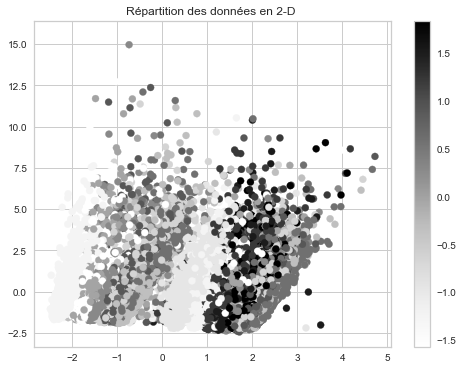

In [15]:
# Répartition des données en 2-D (coloré par mois)
plt.figure(figsize=(8,6))
plt.scatter(pca_projection[:,0],pca_projection[:,1], c=data_pca['mois'])
plt.title('Répartition des données en 2-D ')
plt.colorbar()
plt.savefig('images/Répartition_des_données.png')

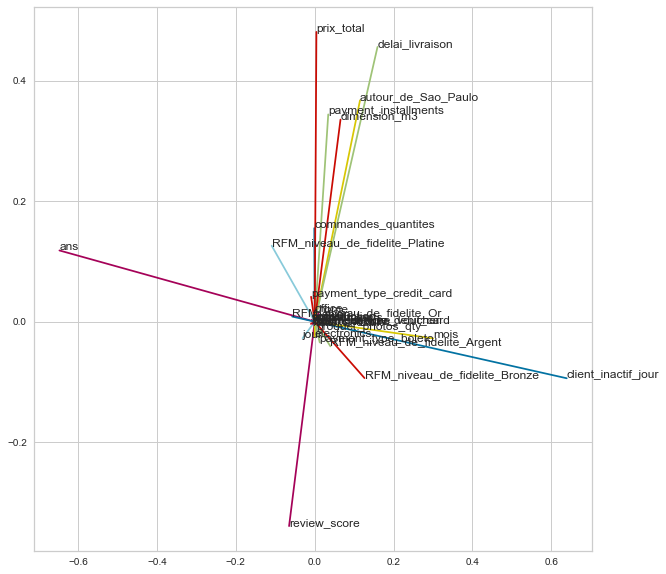

In [16]:
# Emplacement de 22 variables  l'un par rapport à  l'autres
pcs = pca.components_
plt.figure(figsize=(10,10))
for i , (n,m) in enumerate(zip(pcs[0,:],pcs[1,:])):
    plt.plot([0,n],[0,m])
    plt.text(n,m,data_pca.columns[i])
plt.savefig('images/pca_components.png')    

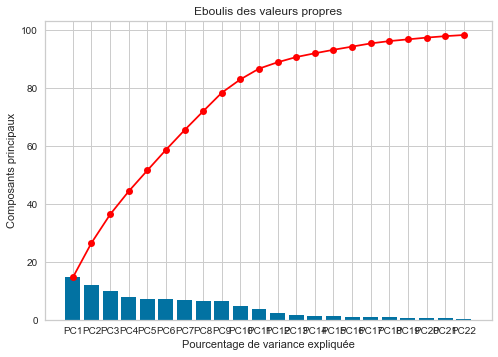

<Figure size 576x396 with 0 Axes>

In [17]:
def display_scree_plot(pca):
    scree = np.round(pca.explained_variance_ratio_*100,decimals=1)
    labels_model_pca = ['PC' + str(i) for i in range(1, len(scree)+1)]
    plt.bar(np.arange(len(scree))+1, scree,tick_label = labels_model_pca)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel('Pourcentage de variance expliquée')
    plt.ylabel('Composants principaux')
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)
plt.savefig('images/Pourcentage_de_variance_expliquée.png')     
display_scree_plot(pca)   
plt.savefig('images/Pourcentage_de_variance_expliquée.png') 

In [18]:
np.argmax(np.cumsum(pca.explained_variance_ratio_)>=0.98)+1

22

In [19]:
loading_scores = pd.Series(pca.components_[0],index=data_pca.columns)
sorted_loading_scores = loading_scores.abs().sort_values(ascending = False)
top_22_features = sorted_loading_scores[0:22].index.values
print(top_22_features)

['ans' 'client_inactif_jour' 'mois' 'delai_livraison'
 'RFM_niveau_de_fidelite_Bronze' 'autour_de_Sao_Paulo'
 'RFM_niveau_de_fidelite_Platine' 'dimension_m3' 'review_score'
 'RFM_niveau_de_fidelite_Or' 'RFM_niveau_de_fidelite_Argent'
 'payment_installments' 'jour' 'payment_type_boleto' 'other' 'home'
 'health_beauty' 'payment_type_credit_card' 'construction' 'arts' 'auto'
 'payment_type_debit_card']


In [20]:
# Ces features qui auraient pu être ignorés lors de la modélisation, mais chacun d'eux est important pour nous
set(data_pca.columns) -set(top_22_features)

{'appliances',
 'commandes_quantites',
 'electronics',
 'fashion',
 'food_drinks',
 'garden_pets',
 'office',
 'payment_type_voucher',
 'prix_total',
 'product_photos_qty',
 'sports_leisure'}

# TSNE

In [21]:
# Première approche du nombre de groupes
print(data_pca.shape)
data_reduit = data.sample(20000, random_state=42) # pour gagner du temps 
data_pca_reduit = data_pca.sample(20000, random_state=42)

(87493, 33)


# Kmeans

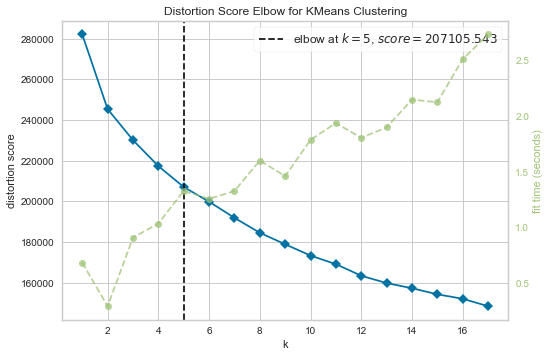

<Figure size 576x396 with 0 Axes>

In [22]:
# Le model de Kmeans nous propose de diviser nos clients en 5 clusters
data_PCA_Kmeans = data_pca_reduit.copy()
km = KMeans(random_state=42)
visualizer = KElbowVisualizer(km, k=(1,18))


visualizer.fit(data_PCA_Kmeans)    
visualizer.poof() 
plt.savefig('images/number_of_clusters.png')

In [23]:

silhouette = []
dict_silhouette = {}
def calcul_silhouette(df,n_clusters):
    for k in range(3,n_clusters):
        kmeans = KMeans(n_clusters=k,
                       random_state=42).fit(df)
        
        silhouette.append(silhouette_score(X = df, labels= kmeans.labels_))
        dict_silhouette[k] = silhouette_score(X = df, labels= kmeans.labels_)
        print('Boucle {} - Silhouette score : {}'.format(k, dict_silhouette[k]))
    return silhouette

In [24]:
n_clusters = 10
silhouettes = calcul_silhouette(data_PCA_Kmeans,n_clusters)


Boucle 3 - Silhouette score : 0.13565857654283667
Boucle 4 - Silhouette score : 0.139809205573428
Boucle 5 - Silhouette score : 0.14399630110304137
Boucle 6 - Silhouette score : 0.12067646870757237
Boucle 7 - Silhouette score : 0.09249580362612364
Boucle 8 - Silhouette score : 0.1156341794396048
Boucle 9 - Silhouette score : 0.08818088205910543


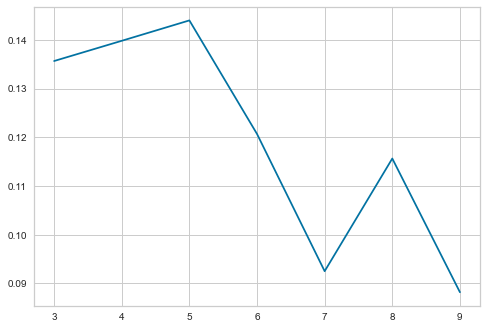

In [25]:
plt.plot(range(3,n_clusters),silhouettes)
plt.savefig('images/number_of_clusters_kmeans.png')

In [26]:
# Pas tres rassurant le coeff 
kmean_reduit_pca = KMeans(n_clusters=5,random_state=42)
kmean_reduit_pca.fit(data_PCA_Kmeans)

KMeans(n_clusters=5, random_state=42)

In [27]:
data_PCA_Kmeans['cluster'] = kmean_reduit_pca.labels_


In [28]:
data_reduit['cluster'] = kmean_reduit_pca.labels_

In [29]:
colors = ["green","blue","yellow","red","orange","skyblue","lime","aqua","brown","pink"]
data_PCA_Kmeans['color'] = data_PCA_Kmeans['cluster'].map(lambda p:colors[p])


<Figure size 504x504 with 0 Axes>

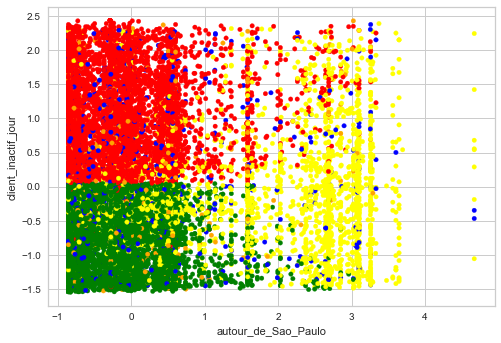

In [30]:
# Les clusters 0 et 1 sont séparés avant et après 300 jours
plt.figure(figsize=(7,7))

data_PCA_Kmeans.plot(y='client_inactif_jour', x='autour_de_Sao_Paulo', kind='scatter',c=data_PCA_Kmeans['color'])
plt.savefig('images/kmeans inactif_local.png')

# data_reduit_client

In [31]:
"""
clusteurs 3 et 1 - max: clients Or (2500 , 2000),    min clusters  4 (400)
clusteurs 3 et 1 - max: clients Platine (1600),      min clusters  5 (250)
clusteurs 3  -     max: clients Argent (+ que 1000), min clusters  4 (180)
clusteurs 5 -      max: clients Bronze (1500),       min clusters  1 (100)
"""
data_reduit_client = data_reduit[['RFM_niveau_de_fidelite_Platine',
       'RFM_niveau_de_fidelite_Or', 'RFM_niveau_de_fidelite_Argent',
       'RFM_niveau_de_fidelite_Bronze','cluster']]

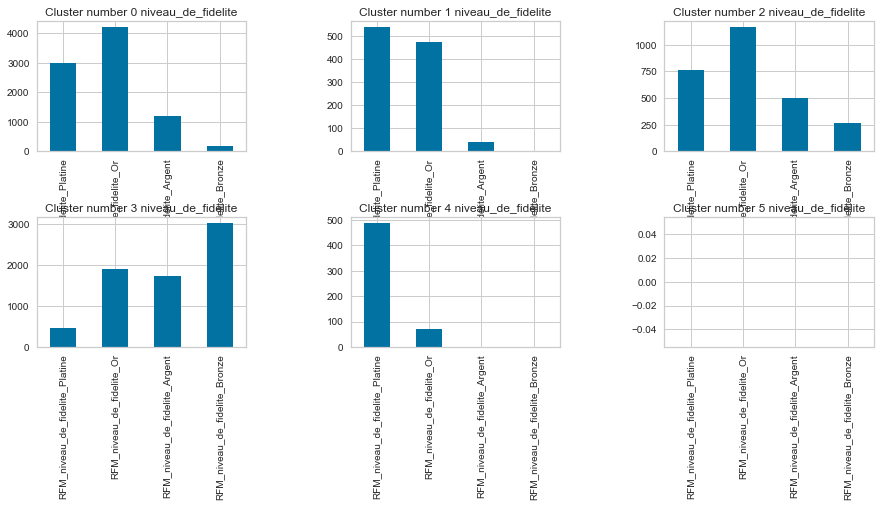

In [32]:
plt.figure(1, figsize=(15,6))
n=0
for x in range(6):
    n+=1
    plt.subplot(2,3,n)
    plt.subplots_adjust(hspace=0.5,wspace=0.5)
    a = (data_reduit_client[data_reduit_client['cluster'] == x].sum())   
    a[:-1].plot(kind = 'bar') 
    plt.title('Cluster number {} niveau_de_fidelite'.format(x))
plt.savefig('images/niveau_de_fidelite.png')    

# data_reduit_produits

In [33]:
data_reduit_produits = data_reduit[['appliances', 'arts', 'auto',
       'construction', 'electronics', 'fashion', 'food_drinks', 'garden_pets',
       'health_beauty', 'home', 'office', 'other', 'sports_leisure','cluster']]

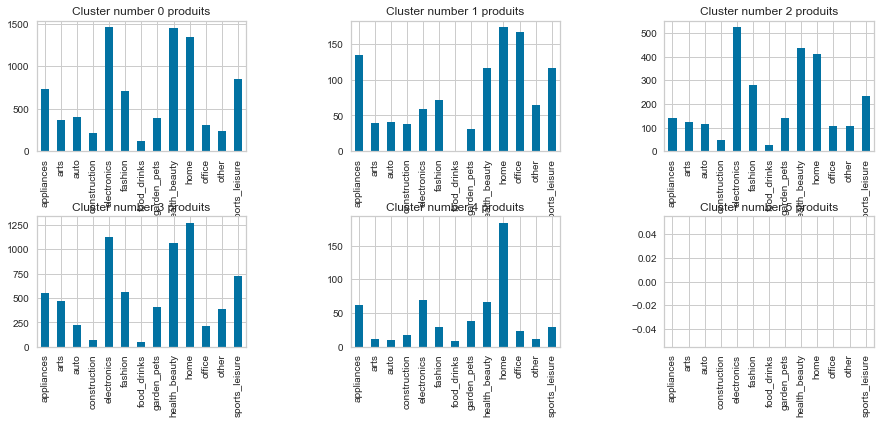

In [34]:
"""
Pour proposer un contrat de maintenance, il faut travailler principalement avec des clients avec du 
level_de_fidelite_Bronze,
car ils sont pour la plupart regroupés en 5  où la valeur 'appliances' est plus faible
"""
plt.figure(1, figsize=(15,6))
n=0
for x in range(6):
    n+=1
    plt.subplot(2,3,n)
    plt.subplots_adjust(hspace=0.5,wspace=0.5)
    a = (data_reduit_produits[data_reduit_produits['cluster'] == x].sum())   
    a[:-1].plot(kind = 'bar') 
    plt.title('Cluster number {} produits'.format(x))
plt.savefig('images/produit.png')      

# data_reduit_RFM

In [35]:
data_reduit_RFM = data_reduit[['delai_livraison', 'dimension_m3','cluster']]

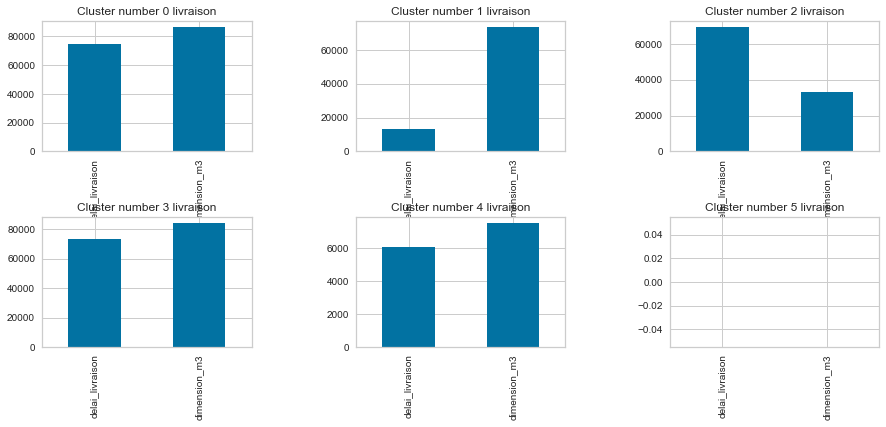

In [36]:
# La plus mouvaise situation on a dans le cluster 3, favorable  - 4
plt.figure(1, figsize=(15,6))
n=0
for x in range(6):
    n+=1
    plt.subplot(2,3,n)
    plt.subplots_adjust(hspace=0.5,wspace=0.5)
    a = (data_reduit_RFM[data_reduit_RFM['cluster'] == x].sum())   
    a[:-1].plot(kind = 'bar') 
    plt.title('Cluster number {} livraison'.format(x))
plt.savefig('images/livraison.png')      

# data_reduit_commercial

In [37]:
data_reduit_commercial  = data_reduit[['commandes_quantites', 'payment_installments',
       'review_score','product_photos_qty','payment_type_boleto',
       'payment_type_credit_card', 'payment_type_debit_card',
       'payment_type_voucher','cluster']]


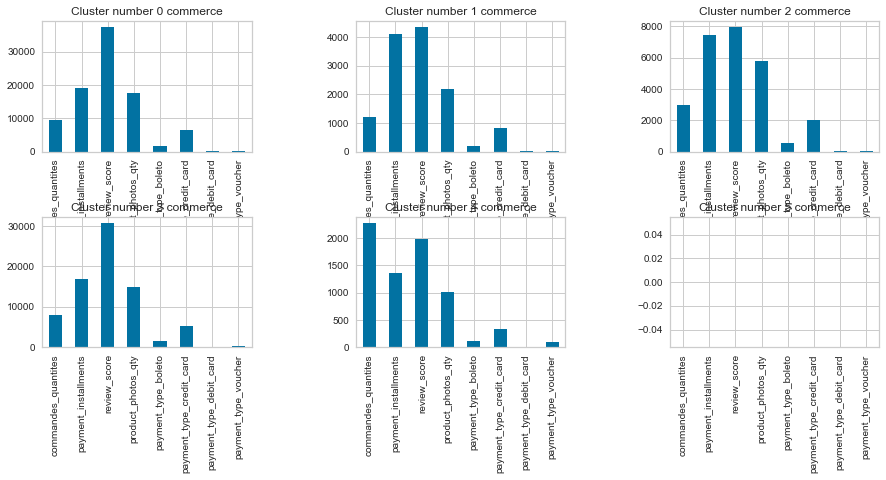

In [38]:
"""
plus de commandes cl 1 et 3
meilleures scores pareil 1 et 3

"""
plt.figure(1, figsize=(15,6))
n=0
for x in range(6):
    n+=1
    plt.subplot(2,3,n)
    plt.subplots_adjust(hspace=0.5,wspace=0.5)
    a = (data_reduit_commercial[data_reduit_commercial['cluster'] == x].sum())   
    a[:-1].plot(kind = 'bar') 
    plt.title('Cluster number {} commerce'.format(x))
plt.savefig('images/commerce.png')      

# AgglomerativeClustering

In [39]:
# Selon le dendrogramme, le jeu de données doit être divisé en 2 parties pour obtenir le score le plus élevé. 
dendrogramme  = sch.dendrogram(sch.linkage(data_reduit.iloc[:,:-1], method="ward"))
plt.savefig('images/dendrogramme.png')

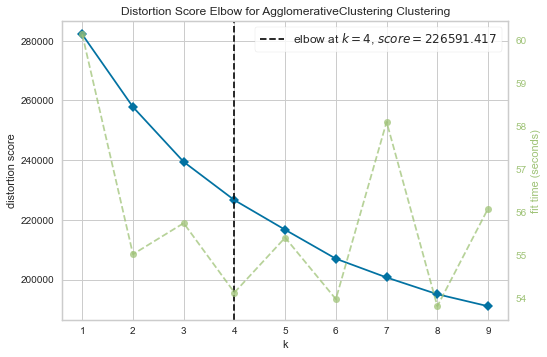

<Figure size 576x396 with 0 Axes>

In [40]:
# 
data_PCA_HC = data_pca_reduit.copy()
model_hc_pca = AgglomerativeClustering()
visualizer = KElbowVisualizer(model_hc_pca, k=(1,10))


visualizer.fit(data_PCA_HC)    
visualizer.poof() 
plt.savefig('images/number_of_clusters.png')

In [41]:

silhouette = []
dict_silhouette = {}

def calcul_silhouette(df,n_clusters):
    for k in range(2,n_clusters):
        hc = AgglomerativeClustering(n_clusters=k).fit(df)
        
        silhouette.append(silhouette_score(X = df, labels= hc.labels_))
        dict_silhouette[k] = silhouette_score(X = df, labels= hc.labels_)
        print('Boucle {} - Silhouette score : {}'.format(k, dict_silhouette[k]))
    return silhouette

In [42]:
n_clusters=10
silhouettes = calcul_silhouette(data_PCA_HC,n_clusters)


Boucle 2 - Silhouette score : 0.08630823460882565
Boucle 3 - Silhouette score : 0.08730361607144901
Boucle 4 - Silhouette score : 0.10218081702735726
Boucle 5 - Silhouette score : 0.11016982182970342
Boucle 6 - Silhouette score : 0.12217664836138577
Boucle 7 - Silhouette score : 0.12748091802147726
Boucle 8 - Silhouette score : 0.08938825332879807
Boucle 9 - Silhouette score : 0.0928958039831904


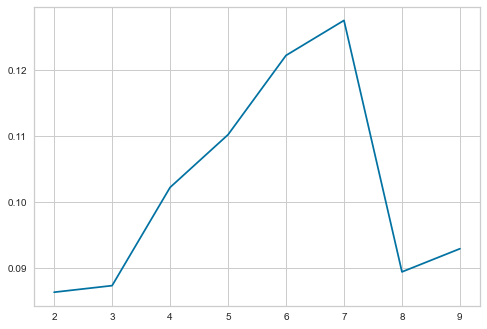

In [43]:
plt.plot(range(2,n_clusters),silhouettes)

In [44]:
# Pas tres rassurant le coeff 
hc_reduit_pca = AgglomerativeClustering(n_clusters=7)
hc_reduit_pca.fit(data_PCA_HC)

AgglomerativeClustering(n_clusters=7)

In [45]:
# data_PCA_HC['cluster'] = hc_reduit_pca.labels_
data_reduit['cluster'] = hc_reduit_pca.labels_


In [46]:
colors = ["green","blue","yellow","red","orange","skyblue","lime","aqua","brown","pink"]
# data_PCA_HC['color'] = data_PCA_HC['cluster'].map(lambda p:colors[p])
data_reduit['color'] = data_reduit['cluster'].map(lambda p:colors[p])

<Figure size 504x504 with 0 Axes>

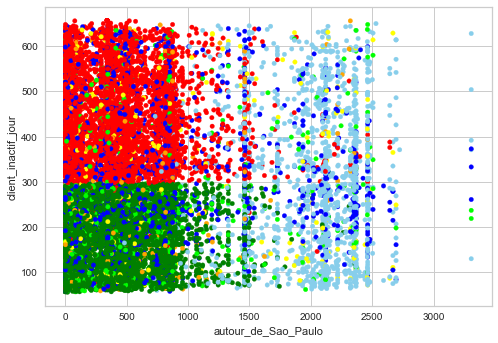

In [47]:
# Les clusters 0 et 1 sont séparés avant et après 300 jours
plt.figure(figsize=(7,7))

data_reduit.plot(y='client_inactif_jour', x='autour_de_Sao_Paulo', kind='scatter',c=data_reduit['color'])
plt.savefig('images/kmeans inactif_local.png')

# DBSCAN

In [48]:
# DBSCAN
data_PCA_dbscan =data_pca_reduit.copy()
model_dbscan = DBSCAN(eps=2.25,min_samples=5).fit(data_PCA_dbscan) 

In [49]:
cluster = model_dbscan.labels_

In [50]:
n_clusters_ = len(set(cluster)) - (1 if -1 in cluster else 0)
n_noise_ = list(cluster).count(-1)
print('number of clusters is',n_clusters_ )
print('number of noises is',n_noise_ )


number of clusters is 10
number of noises is 2106


In [51]:
def show_cluster(X, cluster):
    df=pd.DataFrame(dict(y=X['client_inactif_jour'], x=X['autour_de_Sao_Paulo'], label=cluster))
    colors={-1:'red', 0:'blue', 1:'orange', 2:'green',3:'skyblue',4:'black',
           5:"yellow", 6:"lime", 7:"aqua", 8:"brown",9:"pink"}
    
    fig, ax = plt.subplots(figsize=(8,8))
    grouped=df.groupby('label')
    for key, group in grouped:
        group.plot(ax=ax,kind='scatter', x='x',  y='y',label=key, color=colors[key])
    plt.xlabel('X_1')
    plt.ylabel('X_2')
plt.savefig('images/dbscan_x_y.png')    

<Figure size 576x396 with 0 Axes>

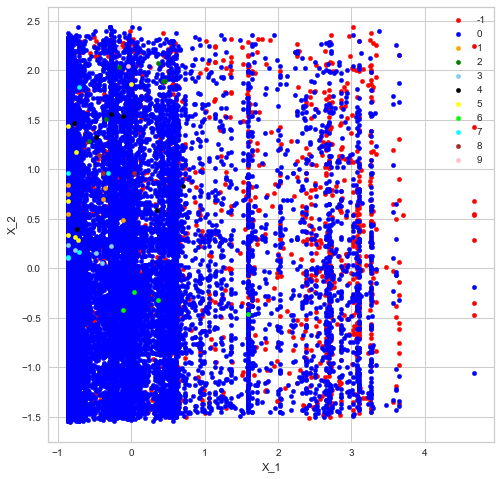

In [52]:
show_cluster(data_PCA_dbscan, cluster)


In [53]:
colors=['red','blue','orange','green','skyblue','black',
           "yellow", "lime","aqua","brown","pink"]
data_PCA_dbscan['cluster'] = model_dbscan.labels_
data_PCA_dbscan['color'] = data_PCA_dbscan['cluster'].map(lambda p:colors[p])

In [54]:
# la visualisation  des clients 
tsne = TSNE(n_components=2)
T = tsne.fit_transform(data_reduit.iloc[:,:-1])


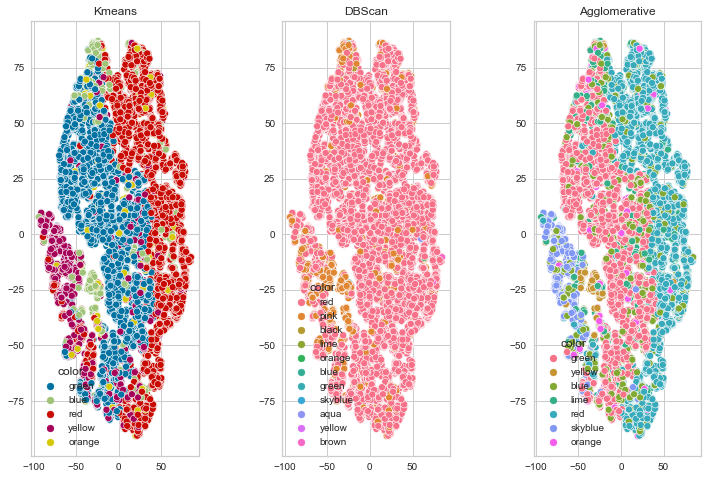

In [55]:
dict_T = [('Kmeans', data_PCA_Kmeans['color']),
          ('DBScan',data_PCA_dbscan['color']),
          ('Agglomerative', data_reduit['color'])]

n=0
for alg,couleur  in dict_T:
    plt.figure(1, figsize=(12,8))      
    n+=1
    plt.subplot(1,3,n)
    plt.subplots_adjust(hspace=0.5,wspace=0.5)
    sns.scatterplot(T[:,0], T[:,1], hue =couleur )
    plt.title(alg)


# Test de faisabilité

### Préparation du nouveau  dataset en retirant les 3 derniers mois

In [56]:
df_avec_date['order_purchase_timestamp'].max()

'2018-09-03 09:06:57'

In [57]:
test_df = df_avec_date[df_avec_date['order_purchase_timestamp']<'2018-06-03 09:06:57']

In [58]:
test_df.drop(columns='order_purchase_timestamp',inplace=True)

In [59]:
test_df.set_index('customer_unique_id',inplace=True)

In [60]:
test_df_reduit  = test_df.sample(20000, random_state=42)

In [61]:
# Variables à standardisées
variables_a_stand  = ['commandes_quantites','payment_installments',
       'prix_total', 'review_score', 'autour_de_Sao_Paulo',
       'product_photos_qty', 'client_inactif_jour', 'delai_livraison',
       'dimension_m3', 'ans', 'mois', 'jour']

In [62]:
test_df_stand = test_df_reduit.copy()

In [63]:
# Un objet
ss_test = StandardScaler()

In [64]:
# Standardisation 
test_df_stand[variables_a_stand] = ss_test.fit_transform(test_df_stand[variables_a_stand])

In [65]:
# test_df_stand_reduit = test_df_stand.sample(20000, random_state=42)

# Kmeans

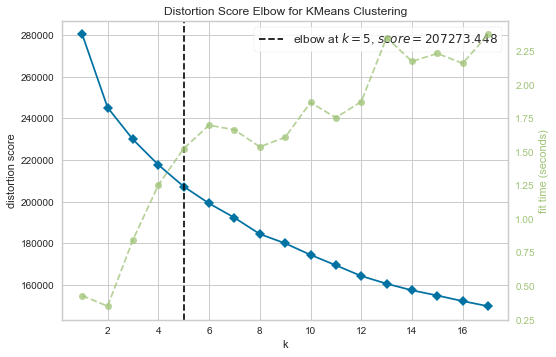

<Figure size 576x396 with 0 Axes>

In [66]:
# Le model de Kmeans pour le test nous propose aussi de diviser nos clients en 5 clusters

km_test = KMeans(random_state=42)
visualizer = KElbowVisualizer(km_test, k=(1,18))


visualizer.fit(test_df_stand)    
visualizer.poof() 
plt.savefig('images/number_of_clusters_test.png')

In [67]:

silhouette = []
dict_silhouette = {}
def calcul_silhouette(df,n_clusters):
    for k in range(3,n_clusters):
        kmeans = KMeans(n_clusters=k,
                       random_state=42).fit(df)
        
        silhouette.append(silhouette_score(X = df, labels= kmeans.labels_))
        dict_silhouette[k] = silhouette_score(X = df, labels= kmeans.labels_)
        print('Boucle {} - Silhouette score : {}'.format(k, dict_silhouette[k]))
    return silhouette

In [68]:
# Le coeff de silhouette 
n_clusters = 10
silhouettes = calcul_silhouette(test_df_stand,n_clusters)


Boucle 3 - Silhouette score : 0.12620737076760274
Boucle 4 - Silhouette score : 0.13068451479300047
Boucle 5 - Silhouette score : 0.13406837005097258
Boucle 6 - Silhouette score : 0.10845534919718694
Boucle 7 - Silhouette score : 0.1410042052065531
Boucle 8 - Silhouette score : 0.10963061709384488
Boucle 9 - Silhouette score : 0.10787951419817417


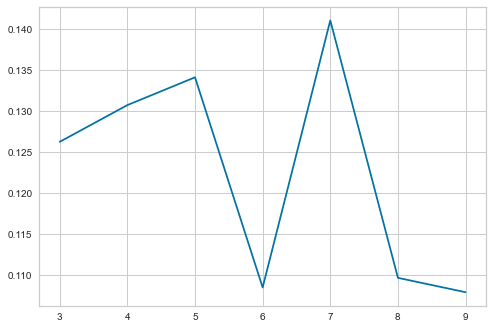

In [69]:
plt.plot(range(3,n_clusters),silhouettes)
plt.savefig('images/number_of_clusters_test.png')

In [70]:
# Pas tres rassurant - pareille 
test_df_clusters = KMeans(n_clusters=5,random_state=42)
test_df_clusters.fit(test_df_stand)

KMeans(n_clusters=5, random_state=42)

In [72]:
# Creation de feature
test_df_reduit['cluster'] = test_df_clusters.labels_

In [73]:
colors = ["green","blue","yellow","red","orange","skyblue","lime","aqua","brown","pink"]
test_df_reduit['color'] = test_df_reduit['cluster'].map(lambda p:colors[p])


<Figure size 504x504 with 0 Axes>

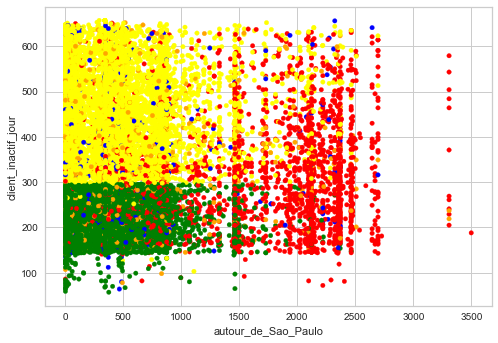

In [74]:
# Les clusters 0 et 1 sont séparés avant et après 300 jours
plt.figure(figsize=(7,7))

test_df_reduit.plot(y='client_inactif_jour', x='autour_de_Sao_Paulo', kind='scatter',c=test_df_reduit['color'])
plt.savefig('images/kmeans inactif_local_test.png')

# 

#### Si les  groupes comparées  de clusters  ont un taux de coïncidence de plus de 70% (plus de 2/3 correspondances), alors on accepte la décision de clustering

# 

In [75]:
# Creation de plusieurs datasets 
cluster_0      = data_reduit[data_reduit['cluster']==0]
cluster_0_test = test_df_reduit[test_df_reduit['cluster']==0]
cluster_1 = data_reduit[data_reduit['cluster']==1]
cluster_1_test = test_df_reduit[test_df_reduit['cluster']==1]
cluster_2 = data_reduit[data_reduit['cluster']==2]
cluster_2_test = test_df_reduit[test_df_reduit['cluster']==2]
cluster_3 = data_reduit[data_reduit['cluster']==3]
cluster_3_test = test_df_reduit[test_df_reduit['cluster']==3]
cluster_4 = data_reduit[data_reduit['cluster']==4]
cluster_4_test = test_df_reduit[test_df_reduit['cluster']==4]




# cluster_0

### Comparaison 

In [76]:
# Origine
(cluster_0[['RFM_niveau_de_fidelite_Platine',
       'RFM_niveau_de_fidelite_Or', 'RFM_niveau_de_fidelite_Argent',
       'RFM_niveau_de_fidelite_Bronze']].sum()/cluster_0[['RFM_niveau_de_fidelite_Platine',
       'RFM_niveau_de_fidelite_Or', 'RFM_niveau_de_fidelite_Argent',
       'RFM_niveau_de_fidelite_Bronze']].sum().sum()*100).sort_values()

RFM_niveau_de_fidelite_Bronze      2.261475
RFM_niveau_de_fidelite_Argent     15.241536
RFM_niveau_de_fidelite_Platine    33.253044
RFM_niveau_de_fidelite_Or         49.243945
dtype: float64

In [77]:
# Test
(cluster_0_test[['RFM_niveau_de_fidelite_Platine',
       'RFM_niveau_de_fidelite_Or', 'RFM_niveau_de_fidelite_Argent',
       'RFM_niveau_de_fidelite_Bronze']].sum()/cluster_0_test[['RFM_niveau_de_fidelite_Platine',
       'RFM_niveau_de_fidelite_Or', 'RFM_niveau_de_fidelite_Argent',
       'RFM_niveau_de_fidelite_Bronze']].sum().sum()*100).sort_values()

RFM_niveau_de_fidelite_Bronze      3.712164
RFM_niveau_de_fidelite_Argent     22.658481
RFM_niveau_de_fidelite_Platine    26.199315
RFM_niveau_de_fidelite_Or         47.430040
dtype: float64

In [78]:
print(101*'-')

-----------------------------------------------------------------------------------------------------


In [79]:
# Origine
(cluster_0[['appliances', 'arts', 'auto',
       'construction', 'electronics', 'fashion', 'food_drinks', 'garden_pets',
       'health_beauty', 'home', 'office', 'other', 'sports_leisure']].mean()).sort_values()

food_drinks       0.016192
construction      0.024756
other             0.027164
office            0.027967
arts              0.043758
auto              0.045363
garden_pets       0.046835
appliances        0.080423
fashion           0.086043
sports_leisure    0.100897
home              0.154690
health_beauty     0.168339
electronics       0.177573
dtype: float64

In [80]:
(cluster_0_test[['appliances', 'arts', 'auto',
       'construction', 'electronics', 'fashion', 'food_drinks', 'garden_pets',
       'health_beauty', 'home', 'office', 'other', 'sports_leisure']].mean()).sort_values()

food_drinks       0.012707
construction      0.022559
other             0.028555
office            0.037836
arts              0.041690
garden_pets       0.046545
auto              0.049400
appliances        0.073387
fashion           0.081668
sports_leisure    0.094232
health_beauty     0.153341
home              0.167476
electronics       0.190605
dtype: float64

In [81]:
print(101*'-')

-----------------------------------------------------------------------------------------------------


In [82]:
# Origine
cluster_0[['delai_livraison', 'dimension_m3']].mean()

delai_livraison    9.069450
dimension_m3       8.649356
dtype: float64

In [83]:
cluster_0_test[['delai_livraison', 'dimension_m3']].mean()

delai_livraison    10.276556
dimension_m3       10.596320
dtype: float64

In [84]:
# Origine
cluster_0[['commandes_quantites', 'payment_installments',
       'review_score','product_photos_qty','payment_type_boleto',
       'payment_type_credit_card', 'payment_type_debit_card',
       'payment_type_voucher']].mean()

commandes_quantites         1.099826
payment_installments        2.233106
review_score                4.622775
product_photos_qty          2.071457
payment_type_boleto         0.201793
payment_type_credit_card    0.754583
payment_type_debit_card     0.022079
payment_type_voucher        0.021544
dtype: float64

In [85]:
cluster_0_test[['commandes_quantites', 'payment_installments',
       'review_score','product_photos_qty','payment_type_boleto',
       'payment_type_credit_card', 'payment_type_debit_card',
       'payment_type_voucher']].mean()

commandes_quantites         1.108509
payment_installments        2.208452
review_score                4.296830
product_photos_qty          2.055111
payment_type_boleto         0.204597
payment_type_credit_card    0.759994
payment_type_debit_card     0.013992
payment_type_voucher        0.021416
dtype: float64

### Les derniers 3 mois ils ont pas mal améliorer leurs résultats (pratiquement dans tous les aspects dans le cluster 0 )

#### Prenons un autre cluster

# cluster_4

In [86]:
# Origine
(cluster_4[['RFM_niveau_de_fidelite_Platine',
       'RFM_niveau_de_fidelite_Or', 'RFM_niveau_de_fidelite_Argent',
       'RFM_niveau_de_fidelite_Bronze']].sum()/cluster_4[['RFM_niveau_de_fidelite_Platine',
       'RFM_niveau_de_fidelite_Or', 'RFM_niveau_de_fidelite_Argent',
       'RFM_niveau_de_fidelite_Bronze']].sum().sum()*100).sort_values()

RFM_niveau_de_fidelite_Argent      0.000000
RFM_niveau_de_fidelite_Bronze      0.000000
RFM_niveau_de_fidelite_Or         12.315271
RFM_niveau_de_fidelite_Platine    87.684729
dtype: float64

In [87]:
(cluster_4_test[['RFM_niveau_de_fidelite_Platine',
       'RFM_niveau_de_fidelite_Or', 'RFM_niveau_de_fidelite_Argent',
       'RFM_niveau_de_fidelite_Bronze']].sum()/cluster_4_test[['RFM_niveau_de_fidelite_Platine',
       'RFM_niveau_de_fidelite_Or', 'RFM_niveau_de_fidelite_Argent',
       'RFM_niveau_de_fidelite_Bronze']].sum().sum()*100).sort_values()

RFM_niveau_de_fidelite_Bronze      0.549451
RFM_niveau_de_fidelite_Argent      5.311355
RFM_niveau_de_fidelite_Platine    39.743590
RFM_niveau_de_fidelite_Or         54.395604
dtype: float64

In [88]:
print(101*'-')

-----------------------------------------------------------------------------------------------------


In [89]:
# Origine
(cluster_4[['appliances', 'arts', 'auto',
       'construction', 'electronics', 'fashion', 'food_drinks', 'garden_pets',
       'health_beauty', 'home', 'office', 'other', 'sports_leisure']].mean()).sort_values()

food_drinks       0.014778
arts              0.017241
auto              0.019704
other             0.019704
construction      0.027094
sports_leisure    0.041872
fashion           0.049261
office            0.061576
garden_pets       0.066502
appliances        0.113300
electronics       0.120690
health_beauty     0.120690
home              0.327586
dtype: float64

In [90]:
(cluster_4_test[['appliances', 'arts', 'auto',
       'construction', 'electronics', 'fashion', 'food_drinks', 'garden_pets',
       'health_beauty', 'home', 'office', 'other', 'sports_leisure']].mean()).sort_values()

food_drinks       0.000916
construction      0.027473
arts              0.032051
garden_pets       0.035714
fashion           0.048535
auto              0.051282
other             0.056777
electronics       0.061355
health_beauty     0.112637
sports_leisure    0.113553
appliances        0.126374
office            0.165751
home              0.167582
dtype: float64

In [91]:
print(101*'-')

-----------------------------------------------------------------------------------------------------


In [92]:
# Origine
cluster_4[['delai_livraison', 'dimension_m3']].mean()

delai_livraison    10.283251
dimension_m3       15.256167
dtype: float64

In [93]:
cluster_4_test[['delai_livraison', 'dimension_m3']].mean()

delai_livraison    13.507326
dimension_m3       72.477420
dtype: float64

In [94]:
# Origine
cluster_4[['commandes_quantites', 'payment_installments',
       'review_score','product_photos_qty','payment_type_boleto',
       'payment_type_credit_card', 'payment_type_debit_card',
       'payment_type_voucher']].mean()

commandes_quantites         4.349754
payment_installments        2.554187
review_score                3.871921
product_photos_qty          1.761084
payment_type_boleto         0.214286
payment_type_credit_card    0.588670
payment_type_debit_card     0.007389
payment_type_voucher        0.189655
dtype: float64

In [95]:
cluster_4_test[['commandes_quantites', 'payment_installments',
       'review_score','product_photos_qty','payment_type_boleto',
       'payment_type_credit_card', 'payment_type_debit_card',
       'payment_type_voucher']].mean()

commandes_quantites         1.141941
payment_installments        4.021978
review_score                3.945055
product_photos_qty          2.134615
payment_type_boleto         0.176740
payment_type_credit_card    0.808608
payment_type_debit_card     0.001832
payment_type_voucher        0.012821
dtype: float64

### Dans le cluster 4 on constate que, il y a des features dans lesquelles nous voyons de grandes différences.


#### Prenons un autre cluster

# cluster_2

In [96]:
# Origine
(cluster_2[['RFM_niveau_de_fidelite_Platine',
       'RFM_niveau_de_fidelite_Or', 'RFM_niveau_de_fidelite_Argent',
       'RFM_niveau_de_fidelite_Bronze']].sum()/cluster_2[['RFM_niveau_de_fidelite_Platine',
       'RFM_niveau_de_fidelite_Or', 'RFM_niveau_de_fidelite_Argent',
       'RFM_niveau_de_fidelite_Bronze']].sum().sum()*100).sort_values()

RFM_niveau_de_fidelite_Argent      0.000000
RFM_niveau_de_fidelite_Bronze      0.217865
RFM_niveau_de_fidelite_Or         49.019608
RFM_niveau_de_fidelite_Platine    50.762527
dtype: float64

In [97]:
(cluster_2_test[['RFM_niveau_de_fidelite_Platine',
       'RFM_niveau_de_fidelite_Or', 'RFM_niveau_de_fidelite_Argent',
       'RFM_niveau_de_fidelite_Bronze']].sum()/cluster_2_test[['RFM_niveau_de_fidelite_Platine',
       'RFM_niveau_de_fidelite_Or', 'RFM_niveau_de_fidelite_Argent',
       'RFM_niveau_de_fidelite_Bronze']].sum().sum()*100).sort_values()

RFM_niveau_de_fidelite_Platine     6.025075
RFM_niveau_de_fidelite_Argent     23.647550
RFM_niveau_de_fidelite_Or         26.468540
RFM_niveau_de_fidelite_Bronze     43.858834
dtype: float64

In [98]:
print(101*'-')

-----------------------------------------------------------------------------------------------------


In [99]:
# Origine
(cluster_2[['appliances', 'arts', 'auto',
       'construction', 'electronics', 'fashion', 'food_drinks', 'garden_pets',
       'health_beauty', 'home', 'office', 'other', 'sports_leisure']].mean()).sort_values()

food_drinks       0.002179
office            0.019608
garden_pets       0.034858
auto              0.039216
construction      0.041394
arts              0.045752
other             0.050109
home              0.063181
appliances        0.067538
sports_leisure    0.074074
electronics       0.150327
health_beauty     0.174292
fashion           0.237473
dtype: float64

In [100]:
(cluster_2_test[['appliances', 'arts', 'auto',
       'construction', 'electronics', 'fashion', 'food_drinks', 'garden_pets',
       'health_beauty', 'home', 'office', 'other', 'sports_leisure']].mean()).sort_values()

food_drinks       0.006849
construction      0.009055
auto              0.028674
office            0.031112
other             0.053518
garden_pets       0.061412
arts              0.065243
appliances        0.071279
fashion           0.079406
sports_leisure    0.098560
health_beauty     0.144764
electronics       0.162526
home              0.187602
dtype: float64

In [101]:
print(101*'-')

-----------------------------------------------------------------------------------------------------


In [102]:
# Origine
cluster_2[['delai_livraison', 'dimension_m3']].mean()

delai_livraison    11.904139
dimension_m3       21.736536
dtype: float64

In [103]:
cluster_2_test[['delai_livraison', 'dimension_m3']].mean()

delai_livraison    10.330857
dimension_m3       11.424196
dtype: float64

In [104]:
# Origine
cluster_2[['commandes_quantites', 'payment_installments',
       'review_score','product_photos_qty','payment_type_boleto',
       'payment_type_credit_card', 'payment_type_debit_card',
       'payment_type_voucher']].mean()

commandes_quantites         1.161220
payment_installments        4.217865
review_score                4.296296
product_photos_qty          2.084967
payment_type_boleto         0.198257
payment_type_credit_card    0.777778
payment_type_debit_card     0.013072
payment_type_voucher        0.010893
dtype: float64

In [105]:
cluster_2_test[['commandes_quantites', 'payment_installments',
       'review_score','product_photos_qty','payment_type_boleto',
       'payment_type_credit_card', 'payment_type_debit_card',
       'payment_type_voucher']].mean()

commandes_quantites         1.104945
payment_installments        2.342698
review_score                4.322614
product_photos_qty          2.093685
payment_type_boleto         0.232180
payment_type_credit_card    0.729046
payment_type_debit_card     0.011957
payment_type_voucher        0.026817
dtype: float64

### Ces résultats sont acceptable sauf les features: dimension_m3,  passage des clients vers catégorie 'Or',et certains produits

# 

### Présentation générale des tableaux

In [119]:
cluster_0.mean()

commandes_quantites                  1.099826
payment_installments                 2.233106
prix_total                         109.645319
review_score                         4.622775
autour_de_Sao_Paulo                333.695370
product_photos_qty                   2.071457
client_inactif_jour                173.143717
delai_livraison                      9.069450
dimension_m3                         8.649356
ans                               2017.999732
mois                                 4.213435
jour                                 3.152683
appliances                           0.080423
arts                                 0.043758
auto                                 0.045363
construction                         0.024756
electronics                          0.177573
fashion                              0.086043
food_drinks                          0.016192
garden_pets                          0.046835
health_beauty                        0.168339
home                              

In [118]:
cluster_0_test.mean()

commandes_quantites                  1.108509
payment_installments                 2.208452
prix_total                         112.327533
review_score                         4.296830
autour_de_Sao_Paulo                333.109552
product_photos_qty                   2.055111
client_inactif_jour                217.237007
delai_livraison                     10.276556
dimension_m3                        10.596320
ans                               2017.992718
mois                                 4.439749
jour                                 3.136208
appliances                           0.073387
arts                                 0.041690
auto                                 0.049400
construction                         0.022559
electronics                          0.190605
fashion                              0.081668
food_drinks                          0.012707
garden_pets                          0.046545
health_beauty                        0.153341
home                              

top_10_features :
    
* 'prix_total' 
* 'dimension_m3' 
* 'autour_de_Sao_Paulo'
<!-- * 'product_photos_qty'
* 'commandes_quantites' 
* 'office' 
* 'RFM_niveau_de_fidelite_Platine'
* 'electronics' 
* 'client_inactif_jour' 
* 'home' -->

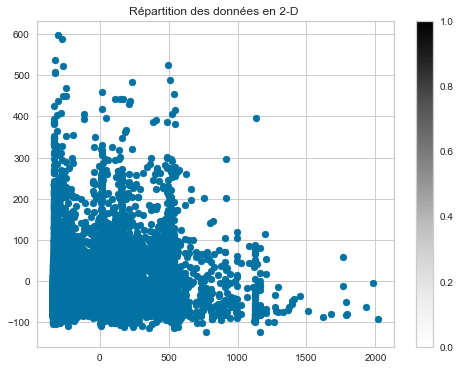

In [107]:
pca=PCA(n_components=0.95)
pca.fit(cluster_0.iloc[:,:-1])
pca.explained_variance_ratio_ 
pca_projection = pca.transform(cluster_0.iloc[:,:-1])
pca_projection.shape
plt.figure(figsize=(8,6))
plt.scatter(pca_projection[:,0],pca_projection[:,1], cmap='brg')
plt.title('Répartition des données en 2-D ')
plt.colorbar()
plt.savefig('images/kmeans_claster0.png')

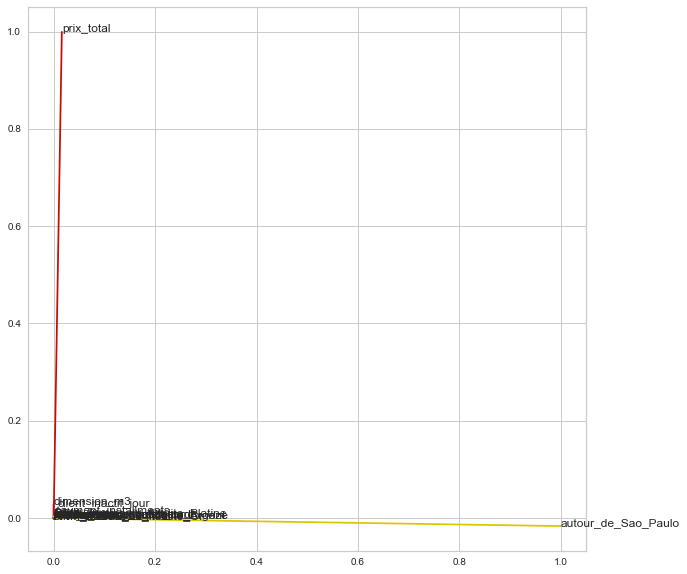

In [108]:

pcs = pca.components_
plt.figure(figsize=(10,10))
for i , (n,m) in enumerate(zip(pcs[0,:],pcs[1,:])):
    plt.plot([0,n],[0,m])
    plt.text(n,m,cluster_0.columns[i])
plt.savefig('images/kmeans_claster01.png')

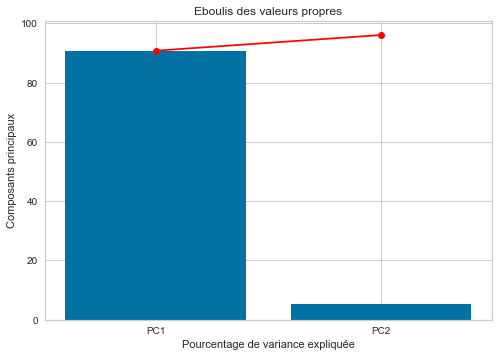

1

<Figure size 576x396 with 0 Axes>

In [109]:
def display_scree_plot(pca):
    scree = np.round(pca.explained_variance_ratio_*100,decimals=1)
    labels_model_pca = ['PC' + str(i) for i in range(1, len(scree)+1)]
    plt.bar(np.arange(len(scree))+1, scree,tick_label = labels_model_pca)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel('Pourcentage de variance expliquée')
    plt.ylabel('Composants principaux')
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)
display_scree_plot(pca) 
plt.savefig('images/kmeans_claster02.png')

np.argmax(np.cumsum(pca.explained_variance_ratio_)>=0.98)+1

In [110]:
loading_scores = pd.Series(pca.components_[0],index=cluster_0.iloc[:,:-1].columns)
sorted_loading_scores = loading_scores.abs().sort_values(ascending = False)
top_3_features_c3 = sorted_loading_scores[0:3].index.values
print(top_3_features_c3)

['autour_de_Sao_Paulo' 'prix_total' 'client_inactif_jour']


In [111]:
cluster_0.describe().T

,count,mean,std,min,25%,50%,75%,max
commandes_quantites,7473.0,1.099826,0.305536,1.000,1.00,1.00,1.00,3.00
payment_installments,7473.0,2.233106,1.887137,0.000,1.00,1.00,3.00,8.00
prix_total,7473.0,109.645319,82.408295,0.310,52.29,86.89,142.44,703.06
review_score,7473.0,4.622775,0.643033,1.000,4.00,5.00,5.00,5.00
autour_de_Sao_Paulo,7473.0,333.695370,339.735081,0.000,19.80,330.90,492.30,2352.60
product_photos_qty,7473.0,2.071457,1.469800,1.000,1.00,1.00,3.00,6.00
client_inactif_jour,7473.0,173.143717,69.330764,56.000,112.00,173.00,232.00,296.00
delai_livraison,7473.0,9.069450,5.704925,0.000,5.00,8.00,12.00,47.00
dimension_m3,7473.0,8.649356,9.318073,0.352,2.52,4.80,11.70,68.62
ans,7473.0,2017.999732,0.016358,2017.000,2018.00,2018.00,2018.00,2018.00


In [112]:
+++

SyntaxError: invalid syntax (<ipython-input-112-2e979968779c>, line 1)

# cluster_1

top_10_features :
    
* 'commandes_quantites' 
* 'prix_total' 
* 'dimension_m3'
* 'payment_installments'
* 'payment_type_credit_card'
* 'payment_type_voucher' 
* 'RFM_niveau_de_fidelite_Platine' 
* 'RFM_niveau_de_fidelite_Or'
* 'delai_livraison' 
* 'client_inactif_jour' 


In [ ]:
pca=PCA(n_components=0.95)
pca.fit(cluster_1)
pca.explained_variance_ratio_ 
pca_projection = pca.transform(cluster_1)
pca_projection.shape
plt.figure(figsize=(8,6))
plt.scatter(pca_projection[:,0],pca_projection[:,1], cmap='brg')
plt.title('Répartition des données en 2-D ')
plt.colorbar()
plt.savefig('images/kmeans_claster1.png')

In [ ]:
pcs = pca.components_
plt.figure(figsize=(10,10))
for i , (n,m) in enumerate(zip(pcs[0,:],pcs[1,:])):
    plt.plot([0,n],[0,m])
    plt.text(n,m,cluster_1.columns[i])
plt.savefig('images/kmeans_claster11.png')    

In [ ]:
def display_scree_plot(pca):
    scree = np.round(pca.explained_variance_ratio_*100,decimals=1)
    labels_model_pca = ['PC' + str(i) for i in range(1, len(scree)+1)]
    plt.bar(np.arange(len(scree))+1, scree,tick_label = labels_model_pca)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel('Pourcentage de variance expliquée')
    plt.ylabel('Composants principaux')
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)
display_scree_plot(pca)   
plt.savefig('images/kmeans_claster12.png')
np.argmax(np.cumsum(pca.explained_variance_ratio_)>=0.95)+1

In [ ]:
loading_scores = pd.Series(pca.components_[0],index=cluster_1.columns)
sorted_loading_scores = loading_scores.abs().sort_values(ascending = False)
top_10_features_cl0 = sorted_loading_scores[0:10].index.values
print(top_10_features_cl0)

# cluster_2

top_10_features :
    
* 'payment_installments' 
* 'jour' 
* 'payment_type_credit_card'
* 'prix_total'
* 'payment_type_boleto' 
* 'RFM_niveau_de_fidelite_Platine' 
* 'RFM_niveau_de_fidelite_Or'
* 'dimension_m3' 
* 'electronics' 
* 'RFM_niveau_de_fidelite_Argent'

In [ ]:
pca=PCA(n_components=0.95)
pca.fit(cluster_2)
pca.explained_variance_ratio_ 
pca_projection = pca.transform(cluster_2)
pca_projection.shape
plt.figure(figsize=(8,6))
plt.scatter(pca_projection[:,0],pca_projection[:,1], cmap='brg')
plt.title('Répartition des données en 2-D ')
plt.colorbar()
plt.savefig('images/kmeans_claster2.png')

In [ ]:
pcs = pca.components_
plt.figure(figsize=(10,10))
for i , (n,m) in enumerate(zip(pcs[0,:],pcs[1,:])):
    plt.plot([0,n],[0,m])
    plt.text(n,m,cluster_2.columns[i])
plt.savefig('images/kmeans_claster21.png')    

In [ ]:
def display_scree_plot(pca):
    scree = np.round(pca.explained_variance_ratio_*100,decimals=1)
    labels_model_pca = ['PC' + str(i) for i in range(1, len(scree)+1)]
    plt.bar(np.arange(len(scree))+1, scree,tick_label = labels_model_pca)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel('Pourcentage de variance expliquée')
    plt.ylabel('Composants principaux')
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)
display_scree_plot(pca)   
plt.savefig('images/kmeans_claster22.png')
np.argmax(np.cumsum(pca.explained_variance_ratio_)>=0.95)+1

In [ ]:
loading_scores = pd.Series(pca.components_[0],index=cluster_2.columns)
sorted_loading_scores = loading_scores.abs().sort_values(ascending = False)
top_10_features_cl0 = sorted_loading_scores[0:10].index.values
print(top_10_features_cl0)

# cluster_3

top_10_features :
    
* 'mois' 
* 'client_inactif_jour' 
* 'payment_installments'
* 'jour'
* 'RFM_niveau_de_fidelite_Bronze'
* 'RFM_niveau_de_fidelite_Or' 
* 'prix_total' 
* 'payment_type_credit_card'
* 'payment_type_boleto' 
* 'product_photos_qty' 

In [ ]:
pca=PCA(n_components=0.95)
pca.fit(cluster_3)
pca.explained_variance_ratio_ 
pca_projection = pca.transform(cluster_3)
pca_projection.shape
plt.figure(figsize=(8,6))
plt.scatter(pca_projection[:,0],pca_projection[:,1], cmap='brg')
plt.title('Répartition des données en 2-D ')
plt.colorbar()
plt.savefig('images/kmeans_claster3.png')

In [ ]:
pcs = pca.components_
plt.figure(figsize=(10,10))
for i , (n,m) in enumerate(zip(pcs[0,:],pcs[1,:])):
    plt.plot([0,n],[0,m])
    plt.text(n,m,cluster_3.columns[i])
plt.savefig('images/kmeans_claster31.png')    

In [ ]:
def display_scree_plot(pca):
    scree = np.round(pca.explained_variance_ratio_*100,decimals=1)
    labels_model_pca = ['PC' + str(i) for i in range(1, len(scree)+1)]
    plt.bar(np.arange(len(scree))+1, scree,tick_label = labels_model_pca)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel('Pourcentage de variance expliquée')
    plt.ylabel('Composants principaux')
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)
display_scree_plot(pca)   
plt.savefig('images/kmeans_claster32.png')
np.argmax(np.cumsum(pca.explained_variance_ratio_)>=0.95)+1

In [ ]:
loading_scores = pd.Series(pca.components_[0],index=cluster_3.columns)
sorted_loading_scores = loading_scores.abs().sort_values(ascending = False)
top_10_features_cl0 = sorted_loading_scores[0:10].index.values
print(top_10_features_cl0)

# cluster_4

top_10_features :
    
* 'delai_livraison' 
* 'autour_de_Sao_Paulo' 
* 'review_score'
* 'ans'
* 'payment_installments'
* 'product_photos_qty' 
* 'dimension_m3' 
* 'prix_total'
* 'home' 
* 'client_inactif_jour' 

In [ ]:
pca=PCA(n_components=0.95)
pca.fit(cluster_4)
pca.explained_variance_ratio_ 
pca_projection = pca.transform(cluster_4)
pca_projection.shape
plt.figure(figsize=(8,6))
plt.scatter(pca_projection[:,0],pca_projection[:,1], cmap='brg')
plt.title('Répartition des données en 2-D ')
plt.colorbar()
plt.savefig('images/kmeans_claster4.png')

In [ ]:
pcs = pca.components_
plt.figure(figsize=(10,10))
for i , (n,m) in enumerate(zip(pcs[0,:],pcs[1,:])):
    plt.plot([0,n],[0,m])
    plt.text(n,m,cluster_4.columns[i])
plt.savefig('images/kmeans_claster41.png')    

In [ ]:
def display_scree_plot(pca):
    scree = np.round(pca.explained_variance_ratio_*100,decimals=1)
    labels_model_pca = ['PC' + str(i) for i in range(1, len(scree)+1)]
    plt.bar(np.arange(len(scree))+1, scree,tick_label = labels_model_pca)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel('Pourcentage de variance expliquée')
    plt.ylabel('Composants principaux')
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)
display_scree_plot(pca)
plt.savefig('images/kmeans_claster42.png')

np.argmax(np.cumsum(pca.explained_variance_ratio_)>=0.95)+1

In [ ]:
loading_scores = pd.Series(pca.components_[0],index=cluster_4.columns)
sorted_loading_scores = loading_scores.abs().sort_values(ascending = False)
top_10_features_cl0 = sorted_loading_scores[0:10].index.values
print(top_10_features_cl0)

# cluster_5

top_10_features :
    
* 'ans' 
* 'client_inactif_jour' 
* 'mois'
* 'product_photos_qty'
* 'RFM_niveau_de_fidelite_Platine'
* 'RFM_niveau_de_fidelite_Bronze' 
* 'delai_livraison' 
* 'payment_installments'
* 'RFM_niveau_de_fidelite_Argent' 
* 'RFM_niveau_de_fidelite_Or' 

In [ ]:
pca=PCA(n_components=0.95)
pca.fit(cluster_5)
pca.explained_variance_ratio_ 
pca_projection = pca.transform(cluster_5)
pca_projection.shape
plt.figure(figsize=(8,6))
plt.scatter(pca_projection[:,0],pca_projection[:,1], cmap='brg')
plt.title('Répartition des données en 2-D ')
plt.colorbar()
plt.savefig('images/kmeans_claster5.png')

In [ ]:
pcs = pca.components_
plt.figure(figsize=(10,10))
for i , (n,m) in enumerate(zip(pcs[0,:],pcs[1,:])):
    plt.plot([0,n],[0,m])
    plt.text(n,m,cluster_5.columns[i])
plt.savefig('images/kmeans_claster51.png')    

In [ ]:
def display_scree_plot(pca):
    scree = np.round(pca.explained_variance_ratio_*100,decimals=1)
    labels_model_pca = ['PC' + str(i) for i in range(1, len(scree)+1)]
    plt.bar(np.arange(len(scree))+1, scree,tick_label = labels_model_pca)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel('Pourcentage de variance expliquée')
    plt.ylabel('Composants principaux')
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)
display_scree_plot(pca)   
plt.savefig('images/kmeans_claster52.png')
np.argmax(np.cumsum(pca.explained_variance_ratio_)>=0.95)+1

In [ ]:
loading_scores = pd.Series(pca.components_[0],index=cluster_5.columns)
sorted_loading_scores = loading_scores.abs().sort_values(ascending = False)
top_10_features_cl0 = sorted_loading_scores[0:10].index.values
print(top_10_features_cl0)